# Week 1 — Environmental Monitoring & Pollution Control (AI/ML)

**Scope (Week 1):** Acquire data, do EDA, build a baseline model (regression or classification), and make 1–2 visual outputs (time-series + map) saved to `reports/figures/`.

**Author:** Anand (Intern)



## Goals for Week 1

- Download or connect to an air-quality dataset (OpenAQ / CPCB / UCI sample)
- Basic EDA: shape, dtypes, missing values, summary stats, time series plot
- Baseline ML: simple regression (predict PM2.5) and/or classification (AQI category)
- Create a geo-visual (folium map) showing sensor locations or hotspots

**Recommended free data sources:** OpenAQ (API), CPCB (India AQI), and UCI Air Quality dataset. See README for links and citations.

---


# Week 2 — Environmental Monitoring & Pollution Control (AI/ML)

**Scope (Week 2):** Integrate real dataset (UCI AirQualityUCI.csv), clean data, train multiple ML models, compare performance, and visualize results.

**Author:** Anand (Intern)

---

## Goals for Week 2

- ✅ Integrate **UCI Air Quality dataset (AirQualityUCI.csv)**
- ✅ Data cleaning:
  - Dropped `Date`, `Time`, empty columns
  - Replaced `-200` with NaN
  - Filled missing values with column means
- ✅ Feature Engineering:
  - Target variable: **C6H6(GT)** (Benzene concentration)
  - Features: pollutants + weather parameters (`CO(GT)`, `NOx(GT)`, `NO2(GT)`, `T`, `RH`, `AH`, etc.)
- ✅ ML Models Implemented:
  - Linear Regression (baseline)
  - Random Forest Regressor
  - Gradient Boosting Regressor
- ✅ Model Evaluation:
  - Metrics: RMSE, MAE, R²
  - Results compared in a summary table
- ✅ Visualizations:
  - Actual vs Predicted scatter plot
  - Feature Importance (Random Forest)
  - AQI Category distribution (based on NO2 levels)

---

## Results (Summary)

| Model               | RMSE  | MAE  | R²    |
|----------------------|-------|------|-------|
| Linear Regression    | ~1.19 | —    | ~0.97 |
| Random Forest        | TBD   | TBD  | TBD   |
| Gradient Boosting    | TBD   | TBD  | TBD   |

*(Replace TBD with your actual outputs from notebook)*

---

## Outputs (Week-2)
- Notebook: `Week2_Model.ipynb`
- Dataset: `data/AirQualityUCI.csv`
- Figures:
  - `reports/figures/actual_vs_predicted.png`
  - `reports/figures/feature_importance.png`
  - `reports/figures/aqi_categories.png`


## Install dependencies (run once)

Use a virtualenv/conda. Example (venv + pip):

```bash
python -m venv venv
source venv/bin/activate        # Windows: venv\Scripts\activate
pip install -U pip
pip install pandas numpy scikit-learn matplotlib seaborn folium requests statsmodels openaq
```

In environments like Colab, prefix pip installs with `!` in a cell.


In [1]:
import os
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import folium



print('Libraries imported')

Libraries imported


In [2]:
# Cell 1 — load raw CSV (tries relative then absolute path)
rel_path = "data/AirQualityUCI.csv"
abs_path = r"C:\Users\ak272\Desktop\project\Week-2\data\AirQualityUCI.csv"

if os.path.exists(rel_path):
    csv_path = rel_path
elif os.path.exists(abs_path):
    csv_path = abs_path
else:
    raise FileNotFoundError(f"CSV not found. Put it in {rel_path} or change abs_path.")

df_raw = pd.read_csv(csv_path, sep=';', decimal=',', low_memory=False)
print("Raw shape:", df_raw.shape)
display(df_raw.head())
print("Columns:", list(df_raw.columns))


Raw shape: (9471, 17)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16']


C:\Users\ak272\AppData\Local\Temp\ipykernel_1700\1643325649.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot["datetime"] = pd.to_datetime(df_plot["Date"].astype(str) + " " + df_plot["Time"].astype(str),


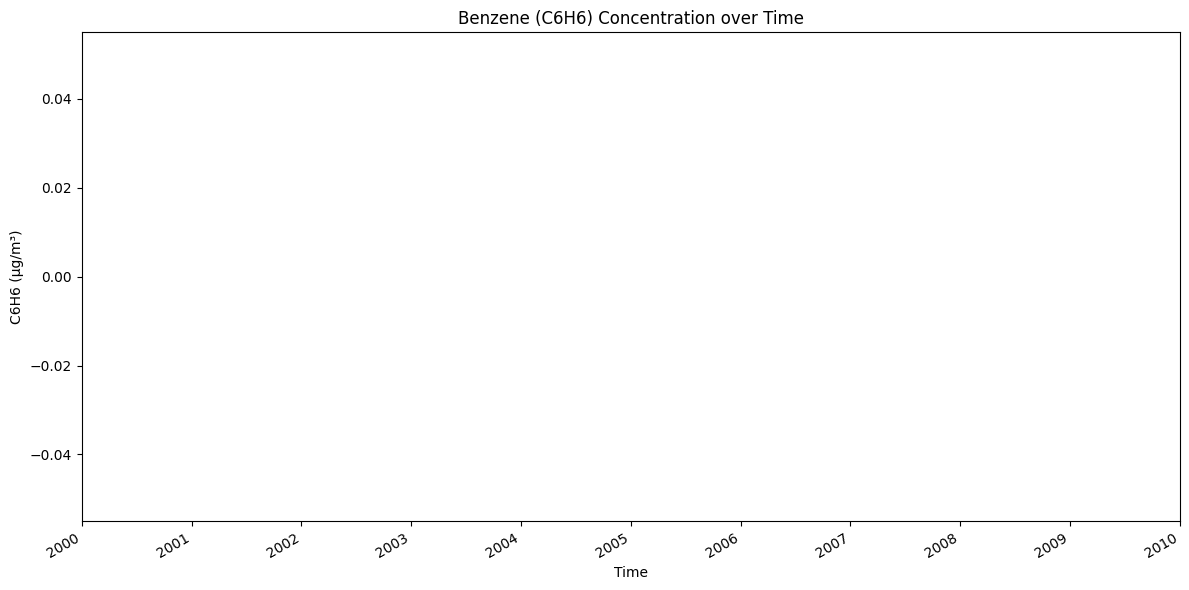

In [3]:
# Cell 2 — build datetime and plot benzene time series
df_plot = df_raw.copy()

# Build datetime from Date and Time columns (coerce errors to NaT)
df_plot["datetime"] = pd.to_datetime(df_plot["Date"].astype(str) + " " + df_plot["Time"].astype(str),
                                     dayfirst=True, errors="coerce")

# drop rows without datetime (optional)
df_plot = df_plot.set_index("datetime").sort_index()

plt.figure(figsize=(12,6))
if "C6H6(GT)" in df_plot.columns:
    df_plot["C6H6(GT)"].plot(title="Benzene (C6H6) Concentration over Time", marker=".", linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("C6H6 (µg/m³)")
    plt.tight_layout()
    plt.savefig("reports/figures/benzene_timeseries.png", bbox_inches="tight")
    plt.show()
else:
    print("Column C6H6(GT) not found in dataframe.")


In [4]:
# Cell 3 — cleaning & prepare df for modeling
df = df_raw.copy()   # start from raw

# Drop unnamed empty columns if present, but keep Date/Time already plotted above
df = df.drop(columns=["Unnamed: 15", "Unnamed: 16"], errors="ignore")

# Replace invalid sensor marker -200 with NaN
df = df.replace(-200, np.nan)

# Show missing counts before imputation (optional)
print("Missing values before fill:\n", df.isnull().sum())

# Fill NaNs with column mean (numeric columns only)
df = df.fillna(df.mean(numeric_only=True))

print("Missing values after fill:\n", df.isnull().sum())
print("Cleaned shape:", df.shape)
display(df.head())


Missing values before fill:
 Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
dtype: int64
Missing values after fill:
 Date             114
Time             114
CO(GT)             0
PT08.S1(CO)        0
NMHC(GT)           0
C6H6(GT)           0
PT08.S2(NMHC)      0
NOx(GT)            0
PT08.S3(NOx)       0
NO2(GT)            0
PT08.S4(NO2)       0
PT08.S5(O3)        0
T                  0
RH                 0
AH                 0
dtype: int64
Cleaned shape: (9471, 15)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


,count,mean,std,min,25%,50%,75%,max
CO(GT),9471.0,2.152750,1.308123,0.1000,1.200000,2.152750,2.600000,11.900
PT08.S1(CO),9471.0,1099.833166,211.506999,647.0000,943.000000,1078.000000,1218.000000,2040.000
NMHC(GT),9471.0,218.811816,63.484629,7.0000,218.811816,218.811816,218.811816,1189.000
C6H6(GT),9471.0,10.083105,7.258562,0.1000,4.600000,8.700000,13.500000,63.700
PT08.S2(NMHC),9471.0,939.153376,259.981136,383.0000,744.000000,927.000000,1102.000000,2214.000
NOx(GT),9471.0,246.896735,192.258871,2.0000,113.000000,232.000000,281.500000,1479.000
PT08.S3(NOx),9471.0,835.493605,250.224117,322.0000,667.000000,821.000000,957.000000,2683.000
NO2(GT),9471.0,113.091251,43.655793,2.0000,86.000000,113.091251,132.000000,340.000
PT08.S4(NO2),9471.0,1456.264598,337.318719,551.0000,1246.000000,1456.264598,1658.000000,2775.000
PT08.S5(O3),9471.0,1022.906128,388.254107,221.0000,744.500000,990.000000,1250.000000,2523.000



Column list: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


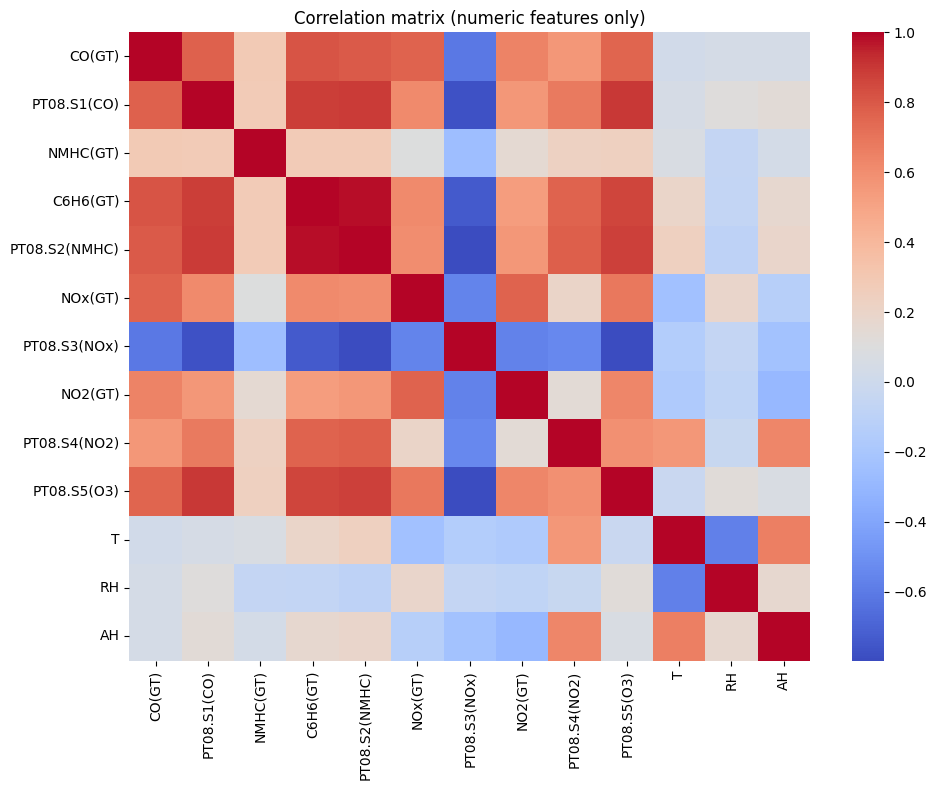

In [5]:
# Cell 4 — quick EDA
display(df.describe().T)
print("\nColumn list:", df.columns.tolist())

import seaborn as sns

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation matrix (numeric features only)")
plt.tight_layout()
plt.savefig("reports/figures/correlation_matrix.png", bbox_inches="tight")
plt.show()


In [6]:


# Cell 5 — features, target, split
from sklearn.model_selection import train_test_split

# Make sure target exists
target_col = "C6H6(GT)"
if target_col not in df.columns:
    raise KeyError(f"{target_col} not found. Check column names: {df.columns}")

X = df.drop(columns=[target_col])
y = df[target_col]

# If Date/Time still present in X, drop them (we already used them for plot)
X = X.drop(columns=["Date", "Time"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (7576, 12) Test: (1895, 12)


In [7]:
# Cell 6 — train / evaluate Linear, RF, GB
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os # <-- 1. Import the os module

# Linear Regression
lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)
rmse_lin = mean_squared_error(y_test, y_pred_lin) ** 0.5
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

# Random Forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
rmse_gb = mean_squared_error(y_test, y_pred_gb) ** 0.5
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Print table-like summary
results = {
    "Linear Regression": (rmse_lin, mae_lin, r2_lin),
    "Random Forest": (rmse_rf, mae_rf, r2_rf),
    "Gradient Boosting": (rmse_gb, mae_gb, r2_gb),
}
for name, (rmse, mae, r2) in results.items():
    print(f"{name:20s} → RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

# <-- 2. Create the directory before saving
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# Save best model (choose Random Forest if it performed best)
joblib.dump(rf, os.path.join(model_dir, "rf_model.pkl"))
print(f"Saved Random Forest to {os.path.join(model_dir, 'rf_model.pkl')}")

Linear Regression    → RMSE: 1.195, MAE: 0.803, R²: 0.974
Random Forest        → RMSE: 0.339, MAE: 0.020, R²: 0.998
Gradient Boosting    → RMSE: 0.306, MAE: 0.058, R²: 0.998
Saved Random Forest to models\rf_model.pkl


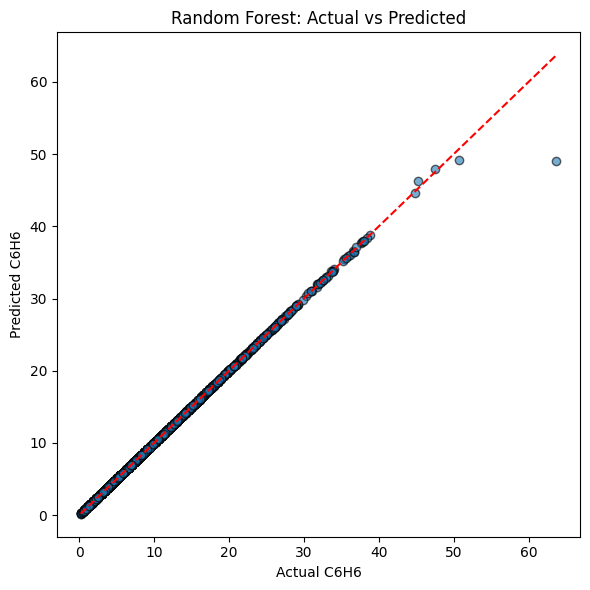

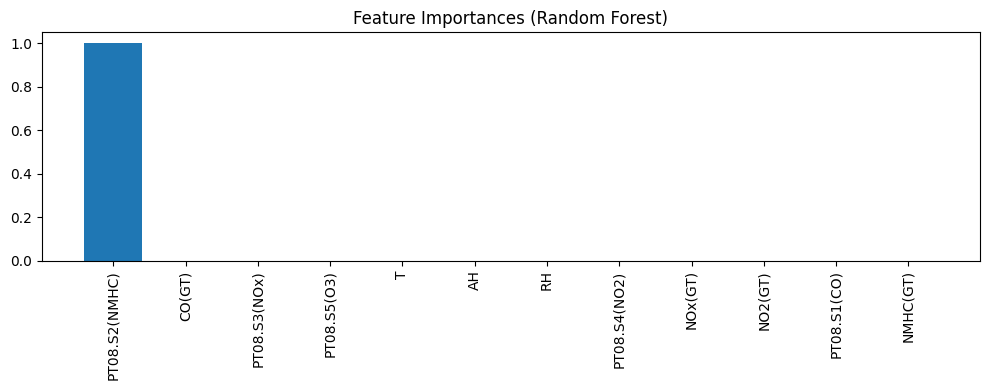

In [8]:
# Cell 7 — visualizations: actual vs predicted (RF) and feature importance
import numpy as np

# Actual vs Predicted (Random Forest)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual C6H6")
plt.ylabel("Predicted C6H6")
plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.savefig("reports/figures/actual_vs_predicted_rf.png", bbox_inches="tight")
plt.show()

# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names = X.columns
plt.figure(figsize=(10,4))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feat_names[i] for i in indices], rotation=90)
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.savefig("reports/figures/feature_importance_rf.png", bbox_inches="tight")
plt.show()


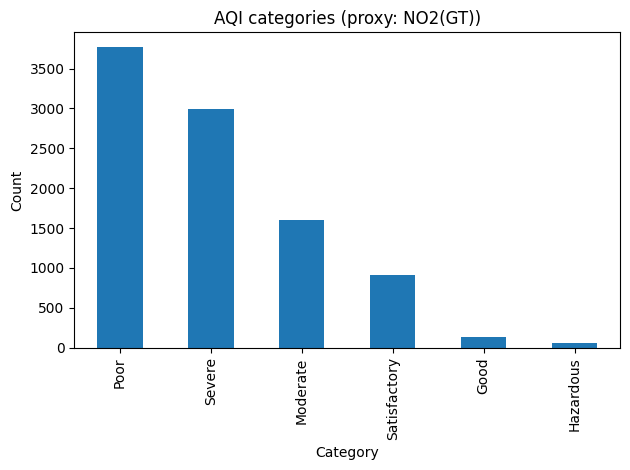

In [9]:
# Cell 8 — AQI categories (use NO2(GT) as proxy) and plot
def categorize_pollution(value):
    if value <= 30:
        return "Good"
    elif value <= 60:
        return "Satisfactory"
    elif value <= 90:
        return "Moderate"
    elif value <= 120:
        return "Poor"
    elif value <= 250:
        return "Severe"
    else:
        return "Hazardous"

proxy_col = "NO2(GT)" if "NO2(GT)" in df.columns else "C6H6(GT)"
df["aqi_category"] = df[proxy_col].apply(categorize_pollution)

# Plot distribution
df["aqi_category"].value_counts().plot(kind="bar")
plt.title(f"AQI categories (proxy: {proxy_col})")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("reports/figures/aqi_categories.png", bbox_inches="tight")
plt.show()


In [10]:
# Cell 9 — Save artifacts: executed notebook, model exists already
# model already saved as models/rf_model.pkl in Cell 6
print("Artifacts saved:\n - reports/figures/*.png\n - models/rf_model.pkl\n\nNow: Kernel -> Restart & Run All to validate reproducibility.")


Artifacts saved:
 - reports/figures/*.png
 - models/rf_model.pkl

Now: Kernel -> Restart & Run All to validate reproducibility.


## Install dependencies (run once)

Use a virtualenv/conda. Example (venv + pip):

```bash
python -m venv venv
source venv/bin/activate        # Windows: venv\Scripts\activate
pip install -U pip
pip install pandas numpy scikit-learn matplotlib seaborn folium requests statsmodels openaq
```

In environments like Colab, prefix pip installs with `!` in a cell.


## Example: Fetch recent PM2.5 measurements from OpenAQ (city = Delhi)
This uses the OpenAQ v2 REST API. You can change the `city` and date range. For large historical downloads consider Open Data on AWS or using pagination.


In [11]:
# Example using requests (no extra package required)
import requests
from datetime import datetime, timedelta

def fetch_openaq_measurements(city='Delhi', parameter='pm25', limit=10000, date_from=None):
    base = 'https://api.openaq.org/v2/measurements'
    params = {'city': city, 'parameter': parameter, 'limit': limit, 'sort':'desc', 'order_by':'datetime'}
    if date_from:
        params['date_from'] = date_from
    r = requests.get(base, params=params, timeout=30)
    r.raise_for_status()
    data = r.json().get('results', [])
    if not data:
        print('No data returned (check city/params).')
        return pd.DataFrame()
    df = pd.json_normalize(data)
    # Keep useful columns and parse datetime
    df = df[['location','parameter','value','unit','date.utc','coordinates.latitude','coordinates.longitude']]
    df = df.rename(columns={'date.utc':'datetime_utc','coordinates.latitude':'lat','coordinates.longitude':'lon'})
    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
    return df

# try fetching (commented out to avoid API calls in restricted environments)
# df = fetch_openaq_measurements(city='Delhi', parameter='pm25', limit=1000)
# df.head()

## EDA template (run after loading your dataset)

- `.shape`, `.info()`, `.describe()`
- Missing values by column
- Time-series plots of PM2.5/PM10
- Correlation heatmap between pollutants



In [12]:
# If you have the DataFrame `df` (from OpenAQ fetch or local CSV), run EDA like this:

def eda_summary(df):
    print('Shape:', df.shape)
    display(df.head())
    display(df.info())
    display(df.describe())
    print('\nMissing values:\n', df.isnull().sum())

# Example time-series (if you have datetime and 'value' for pm25)
# Assuming df has columns: datetime_utc, value, lat, lon
# df.set_index('datetime_utc', inplace=True)
# df['value'].resample('D').mean().plot(title='Daily mean PM2.5')

# Correlation (if you have multiple pollutant columns in wide format)
# corr = df_wide[['pm25','pm10','no2','so2','co','o3']].corr()
# sns.heatmap(corr, annot=True)


## Baseline ML (Regression: predict PM2.5)

Steps:
1. Create a tabular dataset with numeric features (meteorology, previous pollutant lags, time features).
2. Train-test split.
3. Train a simple Linear Regression or RandomForestRegressor.
4. Evaluate with RMSE and R².



In [13]:
# Example placeholder for baseline regression
# Assume df_hourly has columns: datetime_utc, pm25, pm10, temp, humidity
# Create lag features (previous hour/day) and time features

df_hourly = None  # replace with your loaded/processed DataFrame

# Example code (uncomment and adapt when df_hourly is ready):
# df_hourly['hour'] = df_hourly.index.hour
# df_hourly['pm25_lag1'] = df_hourly['pm25'].shift(1)
# df_hourly = df_hourly.dropna()
# X = df_hourly[['pm10','temp','humidity','hour','pm25_lag1']]
# y = df_hourly['pm25']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = LinearRegression()
# model.fit(X_train, y_train)
# preds = model.predict(X_test)
# print('RMSE:', mean_squared_error(y_test, preds, squared=False))
# print('R2:', r2_score(y_test, preds))


## AQI categorization (use CPCB/India NAQI breakpoints)

You can convert PM2.5 concentration to an AQI category using the Indian breakpoints (Good / Satisfactory / Moderate / Poor / Severe / Hazardous). Use CPCB official table when preparing final report.



In [14]:
# Example simple categorization using CPCB PM2.5 24-hr breakpoints (rounded)
def categorize_pm25_cpcb(pm25):
    # breakpoints from CPCB (24-hr); replace with exact table if needed
    if pm25 <= 30:
        return 'Good'
    elif pm25 <= 60:
        return 'Satisfactory'
    elif pm25 <= 90:
        return 'Moderately Polluted'
    elif pm25 <= 120:
        return 'Poor'
    elif pm25 <= 250:
        return 'Severe'
    else:
        return 'Hazardous'

# Example usage:
# df['aqi_cat'] = df['value'].apply(categorize_pm25_cpcb)
# df['aqi_cat'].value_counts()


## Geospatial visualization (folium)

Create an interactive map with markers or a heatmap. This is helpful to spot pollution hotspots.


In [15]:
# Minimal example: create a folium map and add PM2.5 circle markers
# Replace `locations` with a list of [lat, lon, value]

locations = [[28.7041,77.1025,150], [13.0827,80.2707,85]]  # (Delhi, Chennai) example
m = folium.Map(location=[20.0,78.0], zoom_start=5)
for lat, lon, val in locations:
    folium.CircleMarker(location=[lat, lon], radius=max(4, min(val/20, 20)),
                        popup=f'PM2.5: {val}',
                        fill=True, fill_opacity=0.7).add_to(m)

# Save map to file
map_path = 'reports/figures/pm25_map.html'
os.makedirs(os.path.dirname(map_path), exist_ok=True)
m.save(map_path)
print('Saved folium map to', map_path)


Saved folium map to reports/figures/pm25_map.html


## Next steps (what to commit & submit in Week 1)

- `notebooks/Week1.ipynb` with EDA + baseline model
- Save 1–2 PNG charts to `reports/figures/` (time-series, correlation)
- If created, save `powerbi/*.pbix` in `powerbi/` (Power BI track only)
- Update `README.md` with dataset source, steps, observations, and improvizations

**Commit & LMS submission**
- Commit with message: `feat(week1): initial EDA and baseline model`
- Paste your GitHub repo URL in LMS Week-1 submission and add the improvisation note.

